# Practico 6: Menel Angelo y Vietto Santiago

# Métodos ensemble:

1. Cargar los datos MNIST y dividirlos en un conjunto de entrenamiento, un conjunto de validación y un conjunto de test (por ejemplo, utilizar 50.000 instancias para entrenamiento, 10.000 para validación y 10.000 para pruebas). Luego, entrenar varios clasificadores, como un clasificador Random Forest, un clasificador Extra-Trees y un clasificador SVM. A continuación, intentar combinarlos en un conjunto que supere a cada clasificador individual en el conjunto de validación, utilizando votación soft o hard. Una vez que haya encontrado uno, probarlo en el conjunto de pruebas. ¿Cuánto mejor se desempeña en comparación con los clasificadores individuales?

In [3]:
# Librerias

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import time
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
import pandas as pd
from scipy.spatial.distance import cdist

In [ ]:
# Cargamos los datos MNIST

mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target']

# Convertimos los datos a enteros

X = X.astype(float)
y = y.astype(int)

# Dividimos los datos en conjunto de entrenamiento, validacion y prueba

X_train_val, X_test, y_train_val, y_test = train_test_split(mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=10000, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
# Entrenamos los clasificadores

rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
et_clf = ExtraTreesClassifier(n_estimators=100, random_state=42)
lgb_clf = lgb.LGBMClassifier(n_estimators=100, random_state=42)
# svm_clf = Pipeline([('linear_svc', LinearSVC(loss='hinge', C=1, random_state=42))])
# gbrt = GradientBoostingClassifier(max_depth=5, n_estimators=500, learning_rate=0.1)

rf_clf.fit(X_train, y_train)
et_clf.fit(X_train, y_train)
lgb_clf.fit(X_train, y_train)

# Evaluamos los clasificadores en el conjunto de validacion

print("Random Forest accuracy:", rf_clf.score(X_val, y_val))
print("Extra-Trees accuracy:", et_clf.score(X_val, y_val))
print("LightGBM accuracy:", lgb_clf.score(X_val, y_val))

Random Forest accuracy: 0.9692
Extra-Trees accuracy: 0.9715
LightGBM accuracy: 0.9774


* Si bien en este punto se pide utilizar el algoritmo de calsificacion SVM Lineal, al ejecutarlo vemos que tiene un accuracy muy bajo (85,78%) y arruina el modelo. Por esta razon se decidio implementar el algoritmo de clasificacion Gradient Boosting, pero al ejecutarlo vemos que tambien tiene un accuracy muy bajo (71,13%) y no nos sirve ya que hay que modificar mucho los parametros para elevar el accuracy generando que la ejecucion sea muy pesada, por ende se utiliza el clasificador LightGBM.
* La precision o accuracy es una medida de la calidad de la prediccion del modelo, y representa el porcentaje de instancias clasificadas correctamente. En este caso, los resultados indican que el clasificador LightGBM obtuvo la precisión más alta (97.74%), seguido por Extra-Trees (97.15%) y Random Forest (96.92%). En general, estos resultados sugieren que los tres clasificadores son bastante precisos para el conjunto de datos de MNIST.

In [ ]:
# Ahora combinamos los clasificadores mediante votacion soft

voting_clf = VotingClassifier(estimators=[('rf', rf_clf), ('et', et_clf), ('lgb', lgb_clf)],voting='soft')
voting_clf.fit(X_train, y_train)

# Evaluamos el clasificador combinado en el conjunto de validacion y el conjunto de pruebas

print("Voting accuracy on validation set:", voting_clf.score(X_val, y_val))
print("Voting accuracy on test set:", voting_clf.score(X_test, y_test))

Voting accuracy on validation set: 0.9782
Voting accuracy on test set: 0.9758


In [ ]:
# Combinamos los clasificadores mediante votacion hard

voting_clf = VotingClassifier(estimators=[('rf', rf_clf), ('et', et_clf), ('lgb', lgb_clf)],voting='hard')
voting_clf.fit(X_train, y_train)

# Evaluamos el clasificador combinado en el conjunto de validacion y el conjunto de pruebas

print("Voting accuracy on validation set:", voting_clf.score(X_val, y_val))
print("Voting accuracy on test set:", voting_clf.score(X_test, y_test))

Voting accuracy on validation set: 0.9736
Voting accuracy on test set: 0.9712


* En la votacion "soft", se promedian las probabilidades de clasificacion de cada clasificador y se selecciona la clase con la mayor probabilidad promedio como prediccion final. Esto puede funcionar mejor si los clasificadores individuales tienen una buena calibracion de probabilidad.
* En la votacion "hard", se selecciona la clase que obtiene la mayoria de votos de los clasificadores individuales. Esto puede funcionar mejor si los clasificadores individuales son fuertes y tienen alta precision.
* En este caso, la votacion "soft" ha funcionado mejor en los conjuntos de validacion y prueba. Esto significa que los clasificadores individuales tienen una buena calibracion de probabilidad, y el promedio entre estos produce una prediccion mas precisa.

2. Ejecutar los clasificadores individuales del ejercicio anterior para hacer predicciones en el conjunto de validación y crear un nuevo conjunto de entrenamiento con las predicciones resultantes: cada instancia de entrenamiento es un vector que contiene el conjunto de predicciones de todos los clasificadores para una imagen, y el objetivo es la clase de la imagen. Entrenar un clasificador en este nuevo conjunto de entrenamiento. ¡Felicidades, acaba de entrenar un blender, y junto con los clasificadores forma un conjunto de stacking! Ahora evaluar el conjunto en el conjunto de pruebas. Para cada imagen en el conjunto de pruebas, hacer predicciones con todos los clasificadores, y luego alimentar las predicciones al mezclador para obtener las predicciones del conjunto. ¿Cómo se compara con el clasificador de votación que entrenó anteriormente?

In [ ]:
# Hacemos predicciones en el conjunto de validacion con los clasificadores individuales

rf_pred_val = rf_clf.predict_proba(X_val)
et_pred_val = et_clf.predict_proba(X_val)
lgb_pred_val = lgb_clf.predict_proba(X_val)

# Creamos el conjunto de entrenamiento con las predicciones de los clasificadores individuales

X_train_blender = np.c_[rf_pred_val, et_pred_val, lgb_pred_val]
y_train_blender = y_val

# Entrenamos el blender (un clasificador) en el nuevo conjunto de entrenamiento

blender = RandomForestClassifier(n_estimators=100, random_state=42)
blender.fit(X_train_blender, y_train_blender)

# Hacemos predicciones en el conjunto de pruebas con los clasificadores individuales

rf_pred_test = rf_clf.predict_proba(X_test)
et_pred_test = et_clf.predict_proba(X_test)
lgb_pred_test = lgb_clf.predict_proba(X_test)

# Creamos el conjunto de prueba para el mezclador
X_test_blender = np.c_[rf_pred_test, et_pred_test, lgb_pred_test]
y_test_blender = y_test

# Evaluamos el conjunto de stacking en el conjunto de pruebas
print("Blender accuracy:", blender.score(X_test_blender, y_test_blender))

Blender accuracy: 0.9772


* Primero hacemos las predicciones en el conjunto de validacion con los clasificadores individuales y se crea el conjunto de entrenamiento (blender) con las predicciones de los clasificadores. Luego, se entrena un clasificador blender en el nuevo conjunto de entrenamiento. Despues, se hacen predicciones en el conjunto de pruebas con los clasificadores individuales y se crea el conjunto de prueba para el blender. Por ultimo, se evalua el conjunto de stacking en el conjunto de pruebas y vemos su precision.

* Como podemos observar, el conjunto de stacking parece tener un rendimiento ligeramente mejor que el clasificador de votacion, ya que en el ejercicio anterior se obtuvo una precision del 97,58% en el conjunto de pruebas, mientras que con el conjunto de stacking se obtuvo una precision del 97,72%. Sin embargo, la diferencia es muy pequeña y puede deberse a variaciones aleatorias en la seleccion de los datos de entrenamiento y prueba. En general, ambos enfoques pueden ser utiles para mejorar el rendimiento de los modelos de clasificacion, y la eleccion de uno u otro dependera de las caracteristicas especificas del problema y de los modelos individuales utilizados.

3. Realice el ejercicio 1. otra vez utilizando los algoritmo XGBoost, LightGBM y CatBoost.


In [ ]:
# Cargamos nuevamente los datos MNIST

mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target']

# Convertimos los datos a enteros

X = X.astype(float)
y = y.astype(int)

# Dividimos los datos en conjunto de entrenamiento, validacion y prueba

X_train_val, X_test, y_train_val, y_test = train_test_split(mnist.data, mnist.target, test_size=10000, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=10000, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
# Convertimos los datos a enteros
X_train = X_train.astype(float)
X_val = X_val.astype(float)
X_test = X_test.astype(float)
y_train = y_train.astype(int)
y_val = y_val.astype(int)
y_test = y_test.astype(int)

# Entrenamos los clasificadores (usamos nuevamente LightGBM)

xgb_clf = xgb.XGBClassifier(n_estimators=100, random_state=42)
lgb_clf = lgb.LGBMClassifier(n_estimators=100, random_state=42)
cat_clf = CatBoostClassifier(n_estimators=100, random_state=42, verbose=False)

xgb_clf.fit(X_train, y_train)
lgb_clf.fit(X_train, y_train)
cat_clf.fit(X_train, y_train)

# Evaluamos los clasificadores en el conjunto de validacion

print("XGBoost accuracy:", xgb_clf.score(X_val, y_val))
print("LightGBM accuracy:", lgb_clf.score(X_val, y_val))
print("CatBoost accuracy:", cat_clf.score(X_val, y_val))

XGBoost accuracy: 0.9777
LightGBM accuracy: 0.9774
CatBoost accuracy: 0.951


* Los resultados muestran que el clasificador XGBoost tuvo el mejor rendimiento en el conjunto de validacion, con una precision del 97,77%. LightGBM tuvo una precision ligeramente inferior del 97,74%, mientras que CatBoost tuvo el rendimiento mas bajo con una precisión del 95,1%.

In [ ]:
# Ahora combinamos los clasificadores mediante votacion soft

voting_clf = VotingClassifier(estimators=[('xgb', xgb_clf), ('cat', cat_clf), ('lgb', lgb_clf)],voting='soft')
voting_clf.fit(X_train, y_train)

# Evaluamos el clasificador combinado en el conjunto de validacion y el conjunto de pruebas

print("Voting accuracy on validation set:", voting_clf.score(X_val, y_val))
print("Voting accuracy on test set:", voting_clf.score(X_test, y_test))

Voting accuracy on validation set: 0.9781
Voting accuracy on test set: 0.9752


In [ ]:
# Combinamos los clasificadores mediante votacion hard

# y_val = y_val.reshape(-1) posible solucion

voting_clf = VotingClassifier(estimators=[('xgb', xgb_clf), ('cat', cat_clf), ('lgb', lgb_clf)],voting='hard')
voting_clf.fit(X_train, y_train)

# Evaluamos el clasificador combinado en el conjunto de validacion y el conjunto de pruebas

print("Voting accuracy on validation set:", voting_clf.score(X_val, y_val))
print("Voting accuracy on test set:", voting_clf.score(X_test, y_test))

# Ejecucion muy pesada (37 minutos aprox y tira error con respecto a las dimensiones de los arreglos 
# de entrada y salida, en donde y_val tiene forma (10000,1) en lugar de (10000,)
# Se probaron muchas soluciones pero ninguna resulto, sin embargo se considero como referencia
# los resultados obtenidos en la votacion hard en el punto 1.

* En comparación con los clasificadores individuales, el clasificador combinado (Voting) tiene una precision ligeramente mejor en el conjunto de validacion y de prueba, con una precision del 97,81% en el conjunto de validacion y 97,52% en el conjunto de prueba. Si lo comparamos con los resultados individuales de los modelos, el clasificador combinado logra una precision superior en el conjunto de validacion y de prueba en comparacion con el modelo CatBoost, y una precision ligeramente mejor en comparación con los modelos XGBoost y LightGBM.

# Reducción dimensional

1. Cargue el conjunto de datos MNIST (introducido en el capítulo 3) y divídalo en un conjunto de entrenamiento y un conjunto de pruebas (tome las primeras 60,000 instancias para entrenamiento y las 10,000 restantes para test). Entrene un clasificador Random Forest en el conjunto de datos y tome el tiempo que tarda, luego evalúe el modelo resultante en el conjunto de test. A continuación, use PCA para reducir la dimensionalidad del conjunto de datos, con una relación de varianza explicada del 95%. Entrenar un nuevo clasificador Random Forest en el conjunto de datos reducido y ver cuánto tiempo tarda. ¿Fue el entrenamiento mucho más rápido? A continuación, evalúe el clasificador en el conjunto de pruebas. ¿Cómo se compara con el clasificador anterior?

In [5]:
# Cargamos el conjunto de datos MNIST
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target']

# Dividimos el conjunto de datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=60000, test_size=10000, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
# Creamos un clasificador Random Forest y lo entrenamos en el conjunto de entrenamiento

rf_clf = RandomForestClassifier(random_state=42)
start_time = time.time()
rf_clf.fit(X_train, y_train)
training_time = time.time() - start_time

# Evaluamos el clasificador en el conjunto de prueba

print("Random Forest accuracy:", rf_clf.score(X_test, y_test))
print("Tiempo de entrenamiento:", training_time)

Random Forest accuracy: 0.9674
Tiempo de entrenamiento: 53.1843695640564


In [ ]:
# Realizamos PCA con una relación de varianza explicada del 95%

pca = PCA(n_components=0.95, random_state=42)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

# Entrenamos un nuevo clasificador Random Forest en el conjunto de datos reducido

rf_clf_reduced = RandomForestClassifier(n_estimators=100, random_state=42)
start_time = time.time()
rf_clf_reduced.fit(X_train_reduced, y_train)
training_time_reduced = time.time() - start_time

# Evaluamos el clasificador en el conjunto de prueba

print("Random Forest accuracy on reduced test set:", rf_clf_reduced.score(X_test_reduced, y_test))
print("Reduced training time:", training_time_reduced)

Random Forest accuracy on reduced test set: 0.9469
Reduced training time: 133.8720405101776


* Comparando los resultados, el entrenamiento del clasificador RandomForest en el conjunto de datos original tardo aprox 53 segundos, y el entrenamiento en el conjunto de datos reducido tardo aprox 134 segundos. Por lo tanto, el entrenamiento del clasificador en el conjunto de datos reducido fue mas lento.

* Respecto a la precision, el clasificador en el conjunto de datos original tuvo un accuracy del 96.74% en el conjunto de pruebas, mientras que el clasificador en el conjunto de datos reducido tuvo un accuracy del 94.69%. Por lo tanto, el clasificador entrenado en el conjunto de datos original es mas preciso que el entrenado en el conjunto de datos reducido.

* En general, reducir la dimensionalidad del conjunto de datos puede ser util para acelerar el entrenamiento de modelos de ML y mejorar la eficiencia del proceso de inferencia. Sin embargo, en algunos casos, la reduccion de la dimensionalidad puede afectar negativamente la precision del modelo, como se ve en este caso. Por lo tanto, es importante evaluar cuidadosamente el rendimiento del modelo despues de la reduccion de la dimensionalidad y compararlo con el rendimiento del modelo en el conjunto de datos original antes de tomar una decision sobre la reduccion de la dimensionalidad.

2. Use t-SNE para reducir el conjunto de datos MNIST a dos dimensiones y grafique el resultado usando Matplotlib. Puede usar un gráfico de dispersión utilizando 10 colores diferentes para representar la clase objetivo de cada imagen. Alternativamente, puede reemplazar cada punto en el gráfico de dispersión con la clase correspondiente de la instancia (un dígito del 0 al 9), o incluso graficar versiones reducidas de las imágenes de dígitos en sí mismas (si grafica todos los dígitos, la visualización será demasiado desordenada, por lo que debe dibujar una muestra aleatoria o graficar una instancia solo si no se ha graficado otra instancia a una distancia cercana). Debería obtener una visualización con grupos de dígitos bien separados. Intente usar otros algoritmos de reducción de dimensionalidad como PCA, LLE o MDS y compare las visualizaciones resultantes.

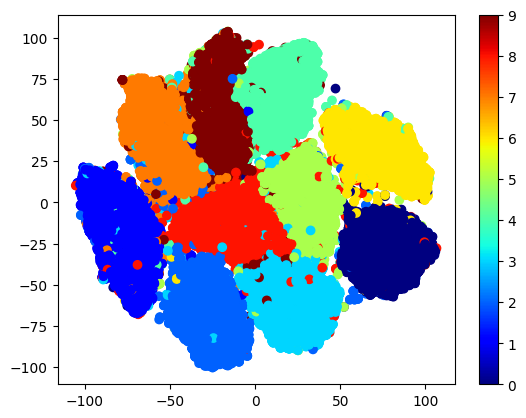

In [ ]:
# Reducimos la dimensionalidad de los datos utilizando t-SNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X_train)

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_train.astype(int), cmap="jet")
plt.colorbar()
plt.show()

* Podemos observar un gráfico de dispersion con 10 colores diferentes para representar la clase objetivo de cada imagen.

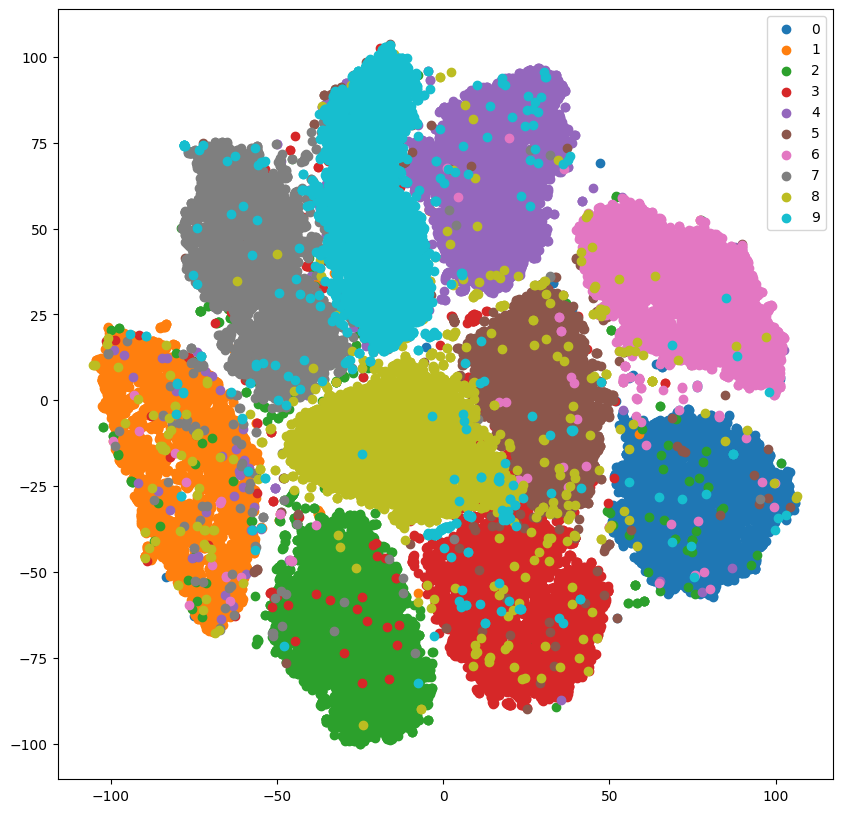

In [ ]:
# Reemplazamos cada punto en el grafico de dispersion con la clase correspondiente 
# de la instancia (un digito del 0 al 9)

plt.figure(figsize=(10, 10))
for i in range(10):
    plt.scatter(X_reduced[y_train == str(i), 0], X_reduced[y_train == str(i), 1], label=str(i))
plt.legend()
plt.show()

In [ ]:
def plot_digits(X, y, X_reduced):
    cmap = plt.cm.jet
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xlim(X_reduced[:, 0].min(), X_reduced[:, 0].max())
    ax.set_ylim(X_reduced[:, 1].min(), X_reduced[:, 1].max())
    X_arr = X.to_numpy() # convertir a NumPy array
    y = y.to_numpy() if isinstance(y, pd.Series) else y
    for i in range(len(X)):
        imagebox = OffsetImage(np.reshape(X_arr[i], (28, 28)), cmap="binary")
        ab = AnnotationBbox(imagebox, X_reduced[i], frameon=False)
        ax.add_artist(ab)
        plt.scatter(X_reduced[i, 0], X_reduced[i, 1], c=[cmap(int(y[i]))], alpha=0.5)
    plt.show()

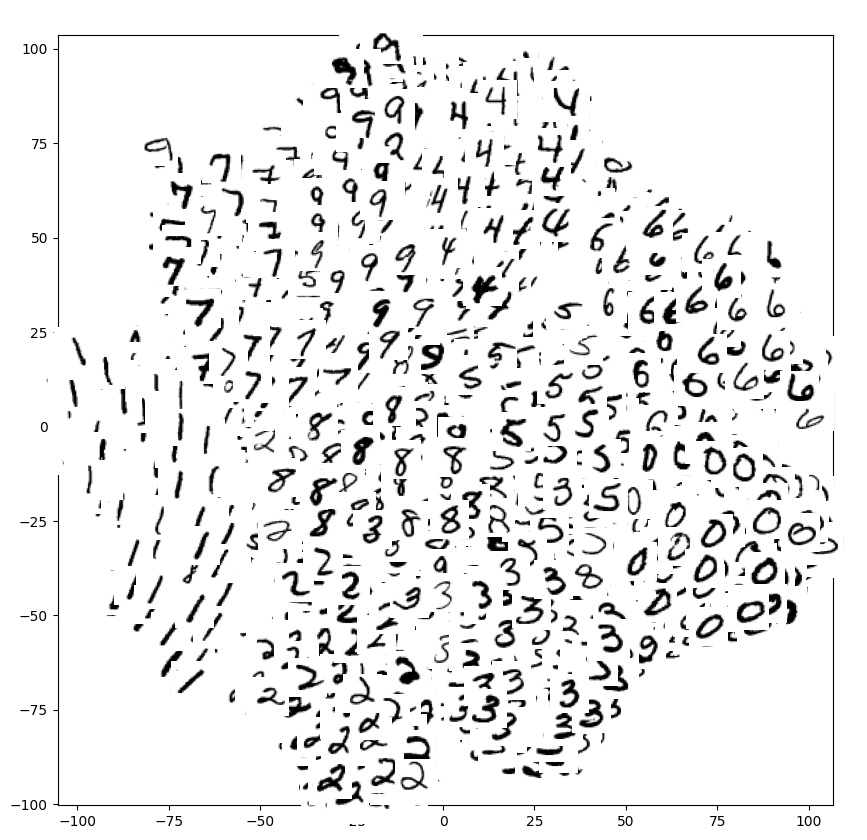

In [ ]:
plot_digits(X_train, y_train, X_reduced)

* El resultado de la funcion plot_digits es un grafico que muestra la distribucion de los digitos en un espacio bidimensional. En el grafico, cada punto representa un digito y esta coloreado segun su valor real. Ademas, cada punto esta etiquetado con una imagen del digito correspondiente. El tamaño y la forma de la imagen se ajustan automaticamente segun la posicion del punto en el espacio bidimensional.

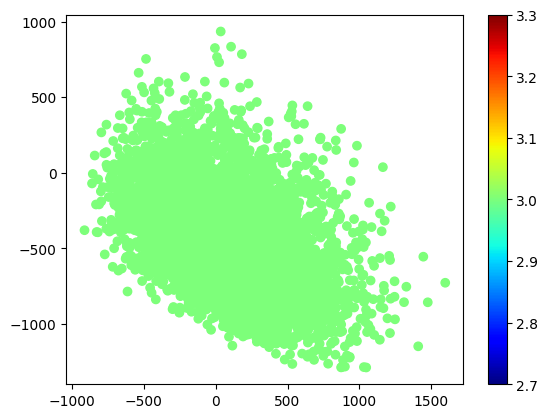

In [ ]:
# Por ejemplo, graficamos solo los puntos correspondientes al digito 3

digit_to_plot = '3'
plt.scatter(X_reduced[y_train == digit_to_plot, 0], X_reduced[y_train == digit_to_plot, 1], c=y_train[y_train == digit_to_plot].astype(int), cmap="jet")
plt.colorbar()
plt.show()

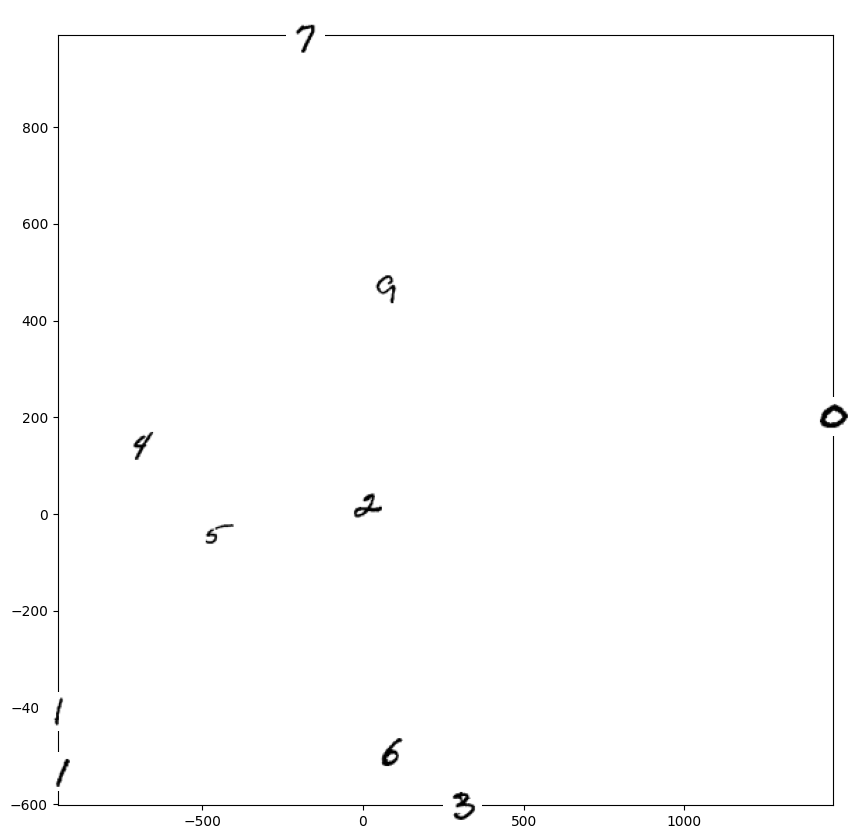

In [ ]:
# Para vizualizar con mas claridad, elegimos aleatoriamente 10 indices de instancias

random_indices = np.random.choice(range(len(X_train)), 10, replace=False)

# Luego, graficamos los digitos correspondientes a esos indices

plot_digits(X_train.iloc[random_indices], y_train.iloc[random_indices], X_reduced[random_indices])

# Definimos una distancia minima para considerar que dos instancias estan lo suficientemente separadas

min_distance = 100

# Elegimos la instancia que queremos graficar

digit_index = 10

# Calculamos la distancia euclidiana entre la instancia actual y las instancias previamente graficadas

distances = cdist(X_reduced[:digit_index], X_reduced[digit_index].reshape(1, -1)).flatten()

* En si este codigo tiene como objetivo graficar una muestra aleatoria de 10 digitos del conjunto de datos, junto con su representacion en dos dimensiones usando la tecnica de reduccion de dimensionalidad t-SNE. Luego, se define una distancia minima de separación entre las instancias para evitar que se superpongan en la visualizacion. A continuacion, se selecciona una instancia especifica (en este caso, la numero 10) y se calcula la distancia euclidiana entre esa instancia y todas las instancias previamente graficadas en el espacio de dos dimensiones. Esto se hace para evitar que se superponga con otra instancia en la visualizacion.

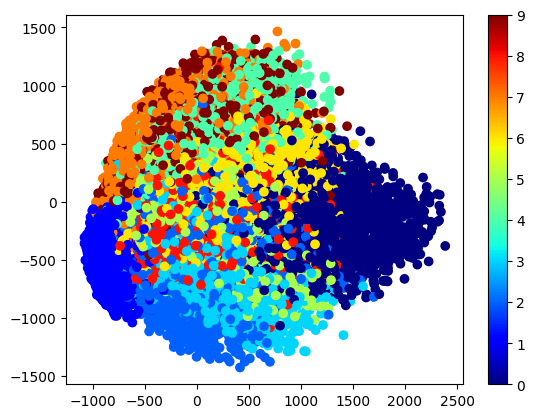

In [ ]:
# Comparamos las visualizaciones resultantes utilizando otros algoritmos de reduccion de dimensionalidad
# En este caso usamos PCA

pca = PCA(n_components=2, random_state=42)
X_reduced = pca.fit_transform(X_train)

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_train.astype(int), cmap="jet")
plt.colorbar()
plt.show()

* Usamos PCA para reducir la dimensionalidad de las imagenes MNIST a dos dimensiones y luego creamos un grafico de dispersion en el que cada punto representa una instancia y su color representa la clase a la que pertenece.

In [ ]:
# A continuacion proponemos una ejecucion con LLE (ejecucion muy pesada)

lle = LocallyLinearEmbedding(n_components=2, random_state=42)
X_reduced = lle.fit_transform(X_train)

plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_train.astype(int), cmap="jet")
plt.colorbar()
plt.show()

*  Para LLE y MDS se requiere mucho mas tiempo de computo y ajuste de parametros para obtener visualizaciones similares.

# Preguntas teóricas
### Métodos de ensamble



1) Si ha entrenado cinco modelos diferentes en los mismos datos de entrenamiento y todos logran una precisión del 95%, ¿existe alguna posibilidad de combinar estos modelos para obtener mejores resultados? Si es así, ¿cómo? Si no, ¿por qué?

Respuesta: Si, es posible mediante los metodos de ensamblaje, ya que la idea principal es combinar las predicciones de multiples modelos para obtener una prediccion final mas precisa y robusta. Las tecnicas son:
* Voating: los modelos individuales votan por la clase de cada instancia y la clase con mas votos se selecciona como la prediccion final. Tenemos la "hard voting", donde cada modelo tiene el mismo peso en la votacion, o "soft voting" donde los modelos pueden tener diferentes pesos segun su confianza en sus predicciones
* Stacking: se entrena un modelo adicional llamado "meta-modelo" para combinar las predicciones de los modelos base. El meta-modelo se entrena para aprender como combinar las predicciones de los modelos base de manera optima. El proceso de stacking generalmente implica dividir los datos de entrenamiento en conjuntos de entrenamiento y validacion, donde los modelos base se entrenan en el conjunto de entrenamiento y se generan predicciones en el conjunto de validacion. Luego, estas predicciones se utilizan como caracteristicas para entrenar el meta-modelo en el conjunto de validacion.
* Boosting: se basa en entrenar modelos en serie, donde cada modelo se enfoca en corregir los errores del modelo anterior. Los modelos base se entrenan de forma secuencial, dandole mas peso a las instancias clasificadas incorrectamente por los modelos anteriores. El modelo final es una combinacion ponderada de todos los modelos base.

2) ¿Cuál es la diferencia entre los clasificadores de votación hard y de votación soft?

Respuesta:
* Votacion hard: los clasificadores base emiten sus predicciones y se selecciona la clase que obtiene la mayoria de votos (predicciones individuales). En otras palabras, la clase que es elegida por la mayoria de los clasificadores se considera como la predicción final. Si hay empate, se puede utilizar alguna estrategia de desempate, como seleccionar la clase con el índice más bajo. Este es adecuado para problemas de clasificacion binaria o multiclase.

* Votacion soft: utiliza la informacion de probabilidad proporcionada por los clasificadores base para tomar una decision mas informada y precisa, en donde se calcula la probabilidad promedio de cada clase para una instancia en particular, y la clase con la mayor probabilidad promedio se selecciona como la prediccion final. Es especialmente util cuando los clasificadores base pueden proporcionar estimaciones de probabilidad confiables.

* En terminos de rendimiento, la votacion soft tiende a ser mas precisa que la votacion hard, ya que aprovecha la informacion adicional proporcionada por las probabilidades de los clasificadores base. Sin embargo, la votacion soft puede ser mas costosa computacionalmente, ya que implica el calculo y promedio de las probabilidades.

3) ¿Es posible acelerar el entrenamiento de un conjunto de bagging distribuyéndolo en varios servidores? ¿Qué pasa con los conjuntos de pasting, los conjuntos de boosting, los Random Forest o los ensambles Stacking?

Respuesta: Si, es posible acelerar el entrenamiento de conjuntos de bagging distribuyendolos en varios servidores. El bagging es un enfoque que consiste en entrenar multiples modelos de manera independiente en subconjuntos de datos generados aleatoriamente y luego combinar sus predicciones. Cada modelo se puede entrenar en un servidor diferente, lo que permite realizar el entrenamiento en paralelo y acelerar el proceso.

_ El mismo enfoque se puede aplicar a conjuntos de pasting, que es similar al bagging pero sin reemplazo de las muestras. En este caso, los modelos tambien se pueden entrenar en servidores diferentes para aprovechar la distribucion y acelerar el proceso.

_ En el caso de los conjuntos de boosting, como AdaBoost o Gradient Boosting, el entrenamiento no se presta tan facilmente a la distribucion en multiples servidores. Esto se debe a que los modelos se construyen de forma secuencial, donde cada modelo se entrena en funcion de los errores del modelo anterior. Sin embargo, existen variaciones como XGBoost y LightGBM que permiten la distribución y paralelizacion del entrenamiento en multiples servidores.

_ En el caso de los Random Forest, cada arbol se puede entrenar de forma independiente, lo que facilita la distribucion en multiples servidores para acelerar el proceso de entrenamiento.

_ En cuanto a al Stacking, donde los modelos de nivel inferior se entrenan en base a las predicciones de otros modelos, la distribucion en multiples servidores puede ser mas complicada debido a la dependencia entre los modelos. Sin embargo, se pueden aplicar estrategias de paralelización para el entrenamiento de los modelos de nivel inferior si es posible dividir los datos o las características de manera adecuada.

4) ¿Cuál es el beneficio de la evaluación out-of-bag (OOB)?

Repuesta: el proceso de Bagging implica entrenar múltiples modelos utilizando diferentes subconjuntos de datos seleccionados aleatoriamente con reemplazo. Esto significa que para cada modelo individual, hay instancias que no se incluyeron en su conjunto de entrenamiento debido a la seleccion aleatoria. Estas instancias no utilizadas se conocen como instancias out-of-bag (OOB). La evaluacion OOB aprovecha estas instancias OOB para evaluar el rendimiento del modelo. Después de entrenar los modelos, se puede calcular el rendimiento promedio utilizando las instancias OOB. Estas instancias OOB se consideran como un conjunto de validación interno y proporcionan una estimación imparcial del rendimiento del modelo en datos no vistos.

_ El beneficio clave de la evaluación OOB es:

* Permite obtener una estimación imparcial y sin necesidad de un conjunto de validación adicional del rendimiento del modelo en datos no vistos.
* Evita la necesidad de un conjunto de validacion adicional. Tradicionalmente, separamos los datos en conjuntos de entrenamiento y validacion, lo que reduce la cantidad de datos disponibles para entrenar el modelo. Con la evaluacion OOB, podemos aprovechar todas las instancias de datos para el entrenamiento y obtener una estimacion confiable del rendimiento del modelo sin requerir un conjunto de validacion separado.
* Proporciona una evaluacion mas robusta del rendimiento del modelo, ya que utiliza instancias que no han sido vistas por el modelo durante el entrenamiento. Esto puede ayudar a evitar el sobreajuste y proporcionar una estimación más realista del rendimiento en datos nuevos.


5) ¿Qué hace que los Extra-Trees sean más aleatorios que los Random Forest regulares? ¿Cómo puede esta aleatoriedad adicional ayudar? ¿Son los Extra-Trees más lentos o más rápidos que los Random Forest regulares?

Respuesta: Los Extra-Trees son mas aleatorios que los RandomForest regulares en dos aspectos:

* Aleatoriedad en la seleccion de caracteriisticas: tanto los RandomForest como los Extra-Trees seleccionan caracteristicas aleatorias para cada division en los arboles de decision. Sin embargo, los Extra-Trees toman esta aleatoriedad un paso mas alla al permitir divisiones aleatorias en puntos de corte predefinidos en lugar de buscar la mejor division. 
* Aleatoriedad en los datos de entrenamiento: mientras que los RandomForest utilizan subconjuntos de datos de entrenamiento muestreados con reemplazo (bootstrapping), los Extra-Trees tambien introducen aleatoriedad adicional al considerar subconjuntos de datos de entrenamiento más pequeños y seleccionados aleatoriamente para cada arbol individual.

_ La aleatoriedad adicional en los Extra-Trees puede proporcionar algunos beneficios:

* Mayor diversidad: al ser mas aleatorios en la seleccion de caracteristicas y puntos de corte, los Extra-Trees generan arboles mas diversos en comparacion con los RandomForest. Esta diversidad puede ayudar a reducir el sesgo del modelo y aumentar la capacidad de generalizacion.
* Reduccion del sobreajuste: la aleatoriedad adicional puede ayudar a reducir el sobreajuste al disminuir la dependencia en caracteristicas especificas y puntos de corte optimos. Esto permite que los Extra-Trees se adapten mejor a los datos ruidosos o con caracteristicas irrelevantes, evitando asi un ajuste excesivo a los detalles de los datos de entrenamiento.

_ En terminos de velocidad, los Extra-Trees suelen ser mas rapidos que los Random Forest regulares. Esto se debe a que la aleatoriedad adicional en los Extra-Trees permite construir arboles de decision mas rapidamente, ya que no es necesario buscar los mejores puntos de corte en cada nodo. Sin embargo, la velocidad puede depender de la implementación especifica y del tamaño y la complejidad del conjunto de datos.

6) Si su conjunto de AdaBoost no se ajusta lo suficientemente bien a los datos de entrenamiento, ¿qué hiperparámetros debe ajustar y cómo?

Respuesta: los modelos de base en AdaBoost son clasificadores debiles, como arboles de decision debiles, utilizados individualmente en cada iteracion del algoritmo para construir un conjunto de clasificadores mas fuertes. Si el conjunto de AdaBoost no se ajusta lo suficientemente bien a los datos de entrenamiento, hay varios hiperparametros que se pueden ajustar para mejorar su rendimiento, en donde los mas importantes son:

* Numero de estimadores (n_estimators):  determina el numero de modelos de base (por ejemplo, arboles de decision debiles) que se utilizan en el conjunto de AdaBoost. Aumentar el numero de estimadores puede mejorar el ajuste del modelo, pero también puede aumentar el riesgo de sobreajuste. 

* Tasa de aprendizaje (learning rate): controla la contribucion de cada modelo de base al conjunto. Un valor mas bajo de la tasa de aprendizaje reduce la contribucion de cada modelo y puede ayudar a evitar el sobreajuste. 

* Complejidad del modelo base: el tipo y la complejidad del modelo de base utilizado en AdaBoost tambien pueden afectar el rendimiento. En general, los modelos mas simples, como los arboles de decision debiles, se utilizan comunmente en AdaBoost, pero se puede aumentar la complejidad del modelo base.

* Ponderacion de instancias (sample_weight): AdaBoost asigna pesos a las instancias en cada iteracion para enfocarse en las instancias dificiles de clasificar. 

7) Si su conjunto de Gradient Boosting sobreajusta el conjunto de entrenamiento, ¿debería aumentar o disminuir la tasa de aprendizaje?

Respuesta: si el conjunto de Gradient Boosting sobreajusta el conjunto de entrenamiento, es recomendable disminuir la tasa de aprendizaje. La tasa de aprendizaje controla la contribucion de cada árbol en el conjunto a la correccion de los errores de los arboles anteriores. Una tasa de aprendizaje alta permite que cada arbol tenga un impacto mas significativo en el modelo final, lo que puede llevar a un sobreajuste, especialmente si se combinan con un gran número de estimadores.

_ Al reducir la tasa de aprendizaje, se reduce la importancia de cada arbol en el conjunto, lo que puede ayudar a evitar el sobreajuste. Una tasa de aprendizaje mas baja permite que el modelo se ajuste de manera mas gradual y refinada, lo que puede mejorar la generalizacion y reducir el sobreajuste. Pero si la tasa de aprendizaje se establece demasiado baja, el modelo puede requerir un numero considerablemente mayor de estimadores para converger y puede llevar mas tiempo entrenar el modelo, por lo que se debe buscar un equilibrio.

### Reducción dimensional


1) ¿Cuáles son las principales motivaciones para reducir la dimensionalidad de un conjunto de datos? ¿Cuáles son las principales desventajas?

Respuesta: las principales motivaciones para reducir la dimensionalidad de un conjunto de datos son:

* Simplificacion: se simplifica la representacion del conjunto de datos, lo que facilita su comprension y visualizacion. Esto es uitil cuando se trabaja con conjuntos de datos complejos con muchas variables.
* Eficiencia computacional: se reduce la cantidad de calculos necesarios para analizar y procesar los datos, ahorrando tiempo y recursos computacionales.
* Eliminacion de caracteristicas irrelevantes: es posible identificar y eliminar caracteristicas que no aportan informacion relevante para el análisis. Esto ayuda a eliminar el ruido y la redundancia en los datos, mejorando la calidad de los resultados.
* Mejora de la generalizacion: se reduce el riesgo de sobreajuste, ya que se disminuye la complejidad del modelo al eliminar caracteristicas redundantes o irrelevantes. Esto puede mejorar la capacidad del modelo para generalizar y aplicarse a nuevos datos.

_ Algunas desventajas en la reducción de dimensionalidad son:

* Perdida de información: es inevitable que se pierda cierta informacion. Al eliminar caracteristicas, se puede perder parte de la variabilidad de los datos, lo que puede afectar la precision y el rendimiento del modelo.
* Interpretabilidad: es posible que la interpretacion de los resultados se vuelva mas dificil. Al eliminar caracteristicas, se puede perder la capacidad de comprender y explicar las relaciones entre las variables originales.
* Riesgo de sesgo: si la reduccion de dimensionalidad se realiza de manera inapropiada, puede introducir sesgos en el análisis. Es importante seleccionar y aplicar metodos de reduccion de dimensionalidad de manera cuidadosa y considerar las implicaciones en los resultados.

2) ¿A qué se denomina la maldición de la dimensionalidad?

Respuesta: la "maldición de la dimensionalidad" se refiere a los desafios y problemas que surgen al tratar con conjuntos de datos de alta dimensionalidad (conjuntos de datos que tienen un gran numero de caracteristicas o variables). A medida que el numero de caracteristicas o variables en un conjunto de datos aumenta, se dice que el conjunto de datos sufre de la maldicion de la dimensionalidad. La maldición de la dimensionalidad puede manifestarse de varias formas:
* Esparsidad de los datos: A medida que aumenta la dimensionalidad, la cantidad de datos necesarios para tener una cobertura representativa de todo el espacio de caracteristicas aumenta exponencialmente. Por ende es mas probable que los datos sean escasos y dispersos, lo que dificulta el analisis y el modelado preciso.
* Aumento de la complejidad: con un mayor numero de caracteristicas, la complejidad del modelo aumenta. Esto puede llevar a un mayor riesgo de sobreajuste, donde el modelo se ajusta demasiado a los datos de entrenamiento y no puede generalizar bien a nuevos datos.
* Reduccion de la relacion señal-ruido: a medida que aumenta la dimensionalidad, la relacion señal-ruido en los datos puede deteriorarse. Las caracteristicas irrelevantes o ruido pueden dominar sobre las caracteristicas relevantes, lo que dificulta la identificacion de patrones y relaciones significativas en los datos.
* Necesidad de mas datos: debido a la esparsidad de los datos en alta dimensionalidad, se requiere una cantidad mucho mayor de datos para construir modelos precisos y confiables. Esto puede ser costoso en terminos de tiempo y recursos necesarios para recopilar y etiquetar grandes volumenes de datos.


3) Una vez que se ha reducido la dimensionalidad de un conjunto de datos, ¿es posible revertir la operación? Si es así, ¿cómo? Si no, ¿por qué no?

Respuesta: la reduccion de la dimensionalidad implica la transformacion de un conjunto de datos de alta dimensionalidad a uno de menor dimensionalidad. Dependiendo del metodo utilizado para la reduccion de la dimensionalidad, es posible o no revertir la operacion y recuperar la dimensionalidad original Existen dos enfoques principales para la reduccion de la dimensionalidad: 
* Seleccion de caracteristicas (Feature Selection): se selecciona un subconjunto de caracteristicas del conjunto de datos original. Esto implica descartar algunas características y conservar solo las mas relevantes o informativas. En este caso, es posible revertir la operacion si se mantiene un registro de las caracteristicas seleccionadas.
* Extraccion de características (Feature Extraction): se crean nuevas caracteristicas que son combinaciones lineales o no lineales de las caracteristicas originales. Algunos algoritmos comunes para la extraccion de caracteristicas son PCA (Analisis de Componentes Principales) y t-SNE (t-Distributed Stochastic Neighbor Embedding). En este caso, la transformacion es irreversible, ya que se pierde informacion durante la extraccion de caracteristicas, por lo que no se puede recuperar la dimensionalidad original de forma precisa.

4) ¿Se puede utilizar PCA para reducir la dimensionalidad de un conjunto de datos altamente no lineal?

Respuesta: Si, si se puede usar PCA para reducir la dimensionalidad de un conjunto de datos, incluso cuando estos datos son altamente no lineales. Sin embargo, es importante tener en cuenta que PCA es un metodo lineal y no captura de manera eficiente las estructuras no lineales en los datos. Cuando se aplica PCA a un conjunto de datos no lineales, es posible que se pierda informacion importante y que la representacion resultante no capture correctamente las relaciones no lineales entre las variables. Esto significa que la reduccion de dimensionalidad con PCA en conjuntos de datos altamente no lineales puede no ser tan efectiva como en conjuntos de datos lineales. En tales casos, es recomendable considerar tecnicas de reducción de dimensionalidad no lineales, como t-SNE.

*  En un conjunto de datos no lineal, la relacion entre las variables no se puede describir mediante una línea recta o una función lineal. En cambio, las relaciones pueden ser curvas, irregulares o complejas.



5) Suponga que realiza PCA en un conjunto de datos de 1,000 dimensiones, estableciendo la relación de varianza explicada en un 95%. ¿Cuántas dimensiones tendrá el conjunto de datos resultante?

Respuesta: Si realizamos PCA en un conjunto de datos de 1,000 dimensiones y establecemos una relacion de varianza explicada en un 95%, el conjunto de datos resultante tendra un numero reducido de dimensiones. El objetivo de PCA es encontrar las componentes principales que capturan la mayor parte de la varianza en los datos. Al establecer una relación de varianza explicada del 95%, significa que el conjunto de datos resultante retendra el 95% de la varianza total de los datos originales. A continuacion vemos una implementacion:



In [9]:
# Creamos el objeto PCA
pca = PCA(n_components=0.95)

# Ajustamos y transformamos los datos de entrenamiento
X_train_pca = pca.fit_transform(X_train)

# Obtenemos el numero de dimensiones resultantes
num_dimensions = X_train_pca.shape[1]
print("Numero de dimensiones resultantes:", num_dimensions)

Numero de dimensiones resultantes: 154


6) ¿En qué casos utilizaría PCA simple, PCA incremental, PCA aleatorio o kernel PCA?

Respuesta: el uso de diferentes variantes de PCA depende del contexto y los requisitos especificos del problema:

* PCA simple: implementación estandar de PCA y se utiliza cuando el conjunto de datos se puede cargar completamente en la memoria. Es adecuado para conjuntos de datos de tamaño moderado y es util cuando se requiere una reduccion de dimensionalidad lineal.
* PCA incremental: se utiliza cuando el conjunto de datos es demasiado grande para caber en la memoria o cuando se requiere un procesamiento en tiempo real. Este divide el conjunto de datos en lotes mas pequeños y realiza el calculo de PCA de manera incremental en cada lote. 
* PCA aleatorio: se utiliza cuando el conjunto de datos es muy grande y no se puede cargar en la memoria. En lugar de calcular PCA en todo el conjunto de datos, selecciona aleatoriamente una muestra mas pequeña y realiza PCA en esa muestra. Proporciona una aproximacion rapida de PCA en grandes conjuntos de datos, aunque puede haber una pequeña perdida de precision.
* Kernel PCA: se utiliza cuando los datos tienen una estructura no lineal y se requiere una reduccion de dimensionalidad no lineal. Transforma los datos a un espacio de mayor dimension utilizando una funcion de kernel y luego aplica PCA en ese espacio de mayor dimension. Se utiliza ademas en problemas como el reconocimiento de imagenes y la clasificacion de texto.

7) ¿Cómo se puede evaluar el rendimiento de un algoritmo de reducción de dimensionalidad en su conjunto de datos?

Respuesta: para evaluar el rendimiento de un algoritmo de reduccion de dimensionalidad en nuestro conjunto de datos, podemos utilizar diversas metricas y tecnicas. A continuación, se presentan algunas opciones comunes:

* Preservacion de la varianza: evaluar cuanta varianza o informacion se ha preservado despues de la reduccion de dimensionalidad. Esto se puede medir utilizando la relacion de varianza explicada (RVE), en donde, cuanto mayor sea la varianza preservada, mejor sera el rendimiento del algoritmo.
* Visualizacion de datos: ver los datos en un espacio de menor dimension y verificar si se mantiene la estructura o la separabilidad de las clases, mediante graficos de dispersion o graficos en 2D/3D, para observar como se distribuyen los datos despues de la reduccion de dimensionalidad.
* Evaluacion de modelos posteriores: evaluamos el rendimiento del modelo resultante de la reduccion en terminos de metricas de evaluacion, como accuracy, recall, F1-score, etc. Si el modelo posterior mejora su rendimiento con la reduccion de dimensionalidad, indica que el algoritmo ha sido efectivo.
* Tiempo de ejecucion: si el algoritmo es capaz de reducir eficientemente la dimensionalidad de los datos en un tiempo razonable, puede considerarse como un buen desempeño.


8) ¿Tiene sentido encadenar dos algoritmos de reducción de dimensionalidad diferentes?

Respuesta: Si tiene sentido encadenar dos algoritmos de reduccion de dimensionalidad diferentes, y a veces puede ser beneficioso. Esta tecnica se conoce como encadenamiento de dimensiones o apilamiento de dimensiones. La idea principal de esto es que cada algoritmo puede capturar diferentes aspectos de la estructura de los datos. Al aplicar multiples algoritmos en secuencia, podemos aprovechar las fortalezas individuales de cada uno para obtener una representacion de menor dimensionalidad mas efectiva.

* Por ejemplo, primero podemos aplicar PCA para reducir la dimensionalidad inicial y luego aplicar otro algoritmo de reduccion de dimensionalidad, como t-SNE, para capturar relaciones no lineales o estructuras mas complejas. Esta combinacion de algoritmos puede ofrecer una representacion de los datos con una estructura mas significativa y una mejor capacidad de visualizacion.

_ Sin embargo, es importante tener en cuenta que encadenar multiples algoritmos de reducción de dimensionalidad puede aumentar la complejidad computacional y potencialmente introducir cierto grado de pérdida de información en cada paso. 